# **MAJOR PROJECT 1 - Malenoma Detection**


## **SEMI SUPERVISED LEARNING**

Semi-supervised machine learning is a combination of supervised and unsupervised machine learning methods. With more common supervised machine learning methods, you train a machine learning algorithm on a “labeled” dataset in which each record includes the outcome information.

## **MOTIVATION BEHIND THE PROJECT:**

In most industry case scenarios, the data is very big and unlabelled. So in order to build a classification model that the cancer is malignant or benign. We use semi-supervised learning to train our GAN model using 2 CNN layers and sigmoid activation function.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import keras
import shutil
import random
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input,Conv2D,LeakyReLU,Flatten,Dropout,Dense,Reshape,Conv2DTranspose,BatchNormalization

In [ ]:
unlabeled_data_gen = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True)
unlabeled_datagen = unlabeled_data_gen.flow_from_directory(directory="/content/drive/MyDrive/MelanomaDetection",
                                                           target_size=(32,32),classes=['unlabeled'],batch_size=256)

In [ ]:
# Define Discriminator neural network
def discriminator():

  dis = Sequential(name="Discriminator")

  # Start adding layers 
  # if the size of the img decrease, channels(=64) increases. Kernal size = 4, means 4x4 matrix
  # alpha = 2, #input channels = 3, after passing conv2d(filters/channel/kernal = 64) -- after leakyReLU - half pixels
  # BatchNormalization - To normalize
  
  dis.add(Conv2D(filters=64,kernel_size=4,strides=2,padding="same",input_shape=(32,32,3),use_bias=False)) 
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Conv2D(filters=128,kernel_size=4,strides=2,padding="same",use_bias=False))
  dis.add(BatchNormalization())  
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Conv2D(filters=256,kernel_size=4,strides=2,padding="same",use_bias=False))
  dis.add(BatchNormalization())
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Flatten())                     # Convert the resultant array into a column vector
  dis.add(Dropout(0.4))                  # Work as a Regularization to prevent over fitting

  dis.add(Dense(units=1,activation="sigmoid"))    # Dense Layer is simple layer of neurons in which each neuron receives input from all the neurons of previous layer

  return dis


# Define Generator neural network
def generator():

  noise_shape = 100                      # Generator will take 100 Dimentional Noise Vector and generate fake imgs of (32,32,3)
  gen = Sequential(name="Generator")

  gen.add(Input(shape=(noise_shape,)))
  gen.add(Dense(units=4*4*100))          # Creating a Dense layer of 1600 Neurons
  gen.add(Reshape((4,4,100)))            # Perform upsampling by De-convolution layer (Transposed Convolution)

  gen.add(Conv2DTranspose(filters=256,kernel_size=4,strides=1,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=128,kernel_size=4,strides=2,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=64,kernel_size=4,strides=2,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=3,kernel_size=4,strides=2,padding="same",activation="tanh",use_bias=False))

  return gen

In [41]:
D = discriminator()

In [42]:
D.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        3072      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         131072    
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 256)         524288    
                                                     

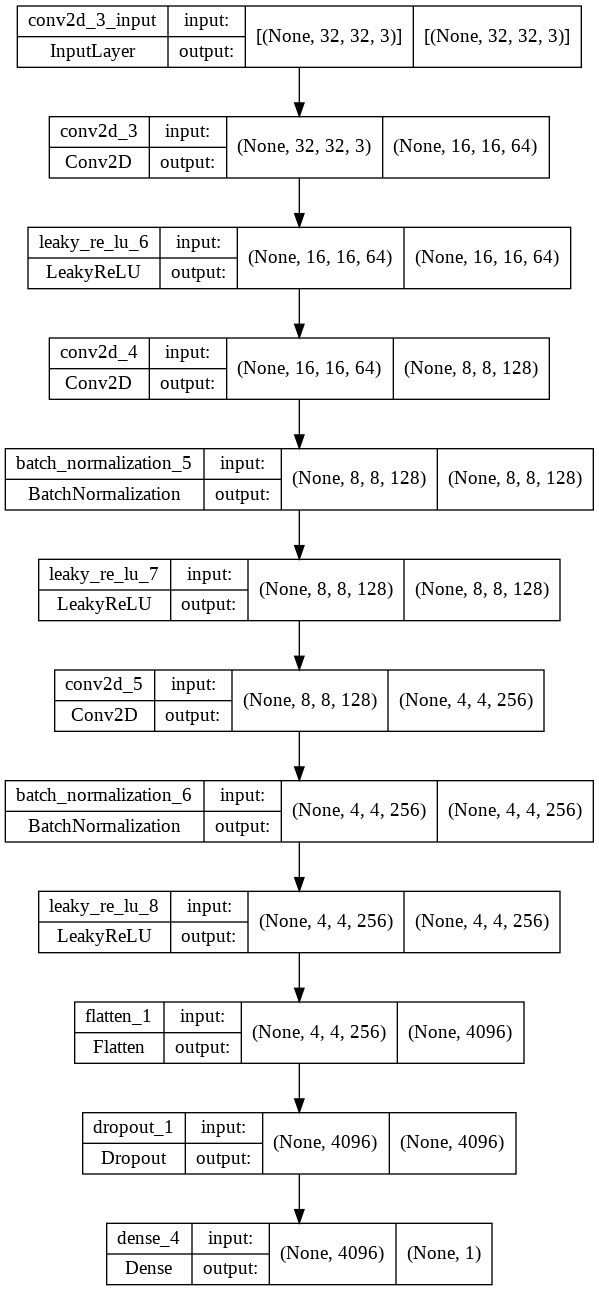

In [43]:
tf.keras.utils.plot_model(model=D,show_shapes=True)

In [44]:
G = generator()

In [45]:
G.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1600)              161600    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 4, 4, 256)        409600    
 ranspose)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 4, 4, 256)        1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 8, 8, 128)        52

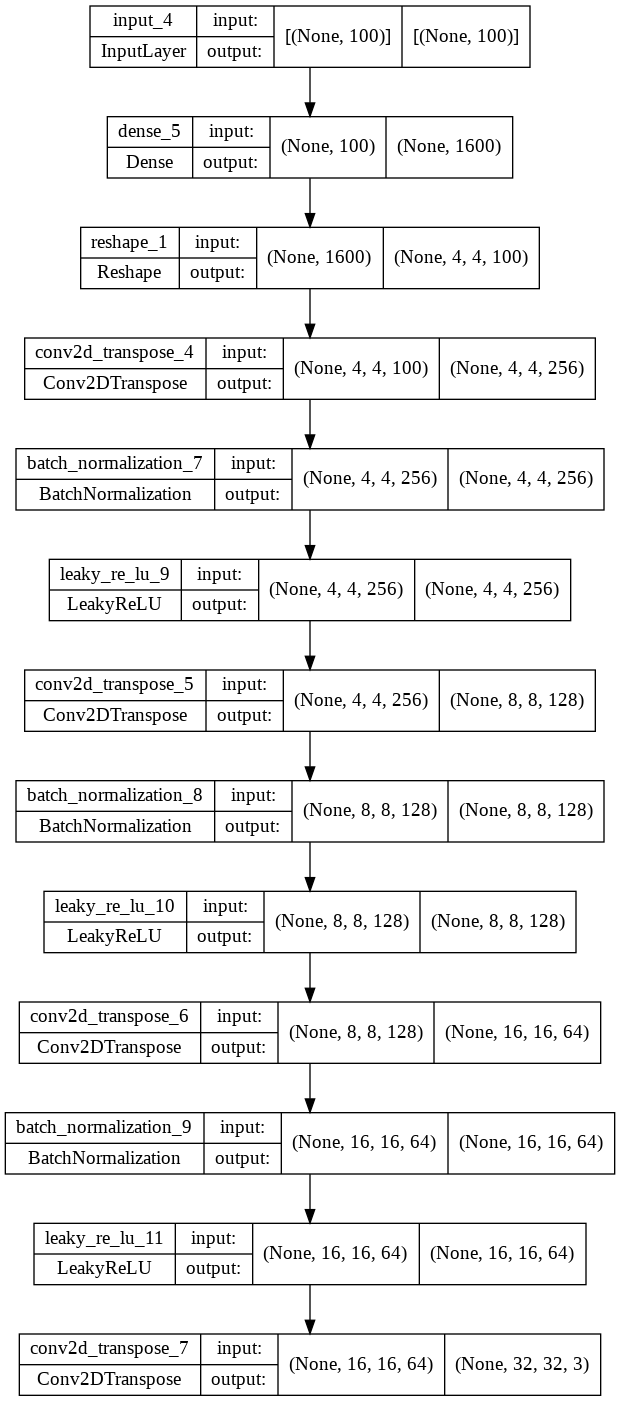

In [46]:
tf.keras.utils.plot_model(model=G,show_shapes=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


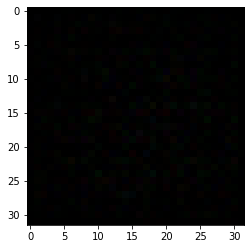

In [47]:
random_noise = tf.random.normal(shape=(1,100))      # Creating a random noise
generated_image = G(random_noise,training=False)    # Output image generated from random noise
plt.imshow(generated_image[0,:,:,:])

In [48]:
posterior = D(generated_image)          # Discriminator will give Posterior Probability as output
print(posterior)

tf.Tensor([[0.5002058]], shape=(1, 1), dtype=float32)


In [49]:
GAN_epochs = 70                   # Number of epochs in total
noise_shape = 100                 # Input
batch_size = 256                  # Size of one batch that will pass through generator

# Create a bce_loss object from keras library 
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [50]:
# Function to calculate Discriminator Loss
def D_loss(real_imgs_preds,fake_imgs_preds):

  real_imgs_labels = 0.05 * tf.random.uniform(shape=tf.shape(real_imgs_preds)) + tf.ones_like(real_imgs_preds) #adding noise to the labels 
  fake_imgs_labels = 0.05 * tf.random.uniform(shape=tf.shape(fake_imgs_preds)) + tf.zeros_like(fake_imgs_preds)

  real_imgs_bce_loss = bce_loss(y_true=real_imgs_labels,y_pred=real_imgs_preds)
  fake_imgs_bce_loss = bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

  total_loss = real_imgs_bce_loss + fake_imgs_bce_loss

  return total_loss

# Function to calculate Generator Loss
def G_loss(fake_imgs_preds):

  fake_imgs_labels = tf.ones_like(fake_imgs_preds)

  return bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

In [51]:
# To optimize the 
D_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0008,beta_1=0.3)
G_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0004,beta_1=0.1)

In [52]:
GAN_checkpoint_dir = "/content/drive/MyDrive/MelanomaDetection/Checkpoint"
GAN_checkpoint_prefix = os.path.join(GAN_checkpoint_dir,"ckpt")
GAN_checkpoint = tf.train.Checkpoint(optimizer=[D_optimizer,G_optimizer],model=[D,G])

In [53]:
@tf.function
#Function to train one epoch - check steps 
def training_step(real_imgs_mini_batch):

  G.trainable = False
  noise = tf.random.normal(shape=(batch_size,noise_shape)) # 256 x 100
  generated_imgs_mini_batch = G(noise,training=False)

  D.trainable = True

  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:

    real_imgs_preds = D(real_imgs_mini_batch,training=True)           # 256 imgs
    fake_imgs_preds = D(generated_imgs_mini_batch,training=True)      # 256 imgs

    disc_loss = D_loss(real_imgs_preds,fake_imgs_preds)               # total imgs input to discriminator = 256 + 256 = 512 imgs

    gradients_of_disc = disc_tape.gradient(disc_loss,D.trainable_variables)                            # Backpropogation
    gradients_of_disc = tf.distribute.get_replica_context().all_reduce('sum', gradients_of_disc)       # Minimize the gradient 
    D_optimizer.apply_gradients(zip(gradients_of_disc,D.trainable_variables),)

    D.trainable = False       # Next Discriminator is freezed
    G.trainable = True        # Generator Unfreeze

    noise = tf.random.normal(shape=(batch_size,noise_shape))          # 256 x 100
    generated_imgs_mini_batch = G(noise,training=True)

    fake_imgs_preds = D(generated_imgs_mini_batch,training=False)

    gen_loss = G_loss(fake_imgs_preds)

    gradients_of_gen = gen_tape.gradient(gen_loss,G.trainable_variables)
    gradients_of_gen = tf.distribute.get_replica_context().all_reduce('sum', gradients_of_gen)
    G_optimizer.apply_gradients(zip(gradients_of_gen,G.trainable_variables))

    #har epoch k baad we insert noisy vectors, then we will check the images. noise will be constant

In [54]:
constant_noise = tf.random.normal(shape=(16,noise_shape))

In [55]:
def generate_and_save_images(generator_model,epoch,test_input):

  #Method to create checkpoints
  generated_sample_images = generator_model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(generated_sample_images.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(generated_sample_images[i,:,:,:])
    plt.axis("off")

  plt.savefig("Images_at_Epoch_{:04d}.png".format(epoch))
  plt.show()

In [56]:
real_imgs_path = "/content/drive/MyDrive/MelanomaDetection/unlabeled"

In [57]:
os.listdir(real_imgs_path)

['380.jpg',
 '1199.jpg',
 '2484.jpg',
 '4787.jpg',
 '357.jpg',
 '431.jpg',
 '5499.jpg',
 '3003.jpg',
 '4793.jpg',
 '1827.jpg',
 '5314.jpg',
 '2490.jpg',
 '4977.jpg',
 '6812.jpg',
 '6190.jpg',
 '4778.jpg',
 '1628.jpg',
 '627.jpg',
 '141.jpg',
 '4744.jpg',
 '4036.jpg',
 '3995.jpg',
 '2862.jpg',
 '2321.jpg',
 '3017.jpg',
 '2309.jpg',
 '4988.jpg',
 '6621.jpg',
 '4750.jpg',
 '1600.jpg',
 '6635.jpg',
 '6153.jpg',
 '2453.jpg',
 '1166.jpg',
 '6609.jpg',
 '6147.jpg',
 '2876.jpg',
 '5300.jpg',
 '3759.jpg',
 '394.jpg',
 '4022.jpg',
 '3771.jpg',
 '2447.jpg',
 '5466.jpg',
 '2335.jpg',
 '3981.jpg',
 '5328.jpg',
 '3201.jpg',
 '828.jpg',
 '3567.jpg',
 '182.jpg',
 '3598.jpg',
 '68.jpg',
 '6386.jpg',
 '5670.jpg',
 '169.jpg',
 '2679.jpg',
 '4585.jpg',
 '3573.jpg',
 '97.jpg',
 '1364.jpg',
 '6379.jpg',
 '1370.jpg',
 '6345.jpg',
 '5116.jpg',
 '4552.jpg',
 '196.jpg',
 '6423.jpg',
 '800.jpg',
 '5857.jpg',
 '2645.jpg',
 '155.jpg',
 '5664.jpg',
 '2692.jpg',
 '5843.jpg',
 '633.jpg',
 '40.jpg',
 '1402.jpg',
 '212

In [58]:
# Function to train GAN model
def train_gan(real_imgs_datagen,total_epochs):

  for epoch in range(total_epochs):

    time_step = 1

    for image_batch in real_imgs_datagen:

      print("Training GAN at Time Step {} of Epoch {}".format(time_step,epoch+1))
      training_step(real_imgs_mini_batch=image_batch[0])

      if time_step > len(os.listdir(real_imgs_path))//batch_size:
        break

      time_step = time_step + 1

    generate_and_save_images(generator_model=G,epoch=epoch+1,test_input=constant_noise)

    if (epoch + 1) % 5 == 0:
      GAN_checkpoint.save(file_prefix=GAN_checkpoint_prefix)

  generate_and_save_images(generator_model=G,epoch=total_epochs,test_input=constant_noise)

In [ ]:
train_gan(real_imgs_datagen=unlabeled_datagen,total_epochs=GAN_epochs)

In [59]:
#create an instance for checkpoint folder
latest_checkpoint_path = tf.train.latest_checkpoint("/content/drive/MyDrive/MelanomaDetection/MelanomaDetectionGAN_training_checkpoints")
latest_checkpoint_path

In [60]:
#  Will return the last checkpoint shape
from tensorflow.python.framework.tensor_shape import as_dimension
GAN_checkpoint.restore(latest_checkpoint_path) 

In [61]:
#Function to show the image generated from generator 
def generate_and_save_images(generator_model,test_input):

  generated_sample_images = generator_model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(generated_sample_images.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(generated_sample_images[i,:,:,:])
    plt.axis("off")

  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

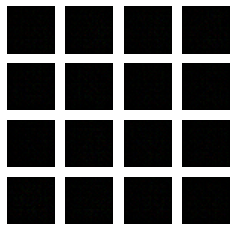

In [62]:
generate_and_save_images(generator_model=G,test_input=constant_noise)

In [63]:
# Real unlabeled images 
unlbld_imgs_base_path = "/content/drive/MyDrive/MelanomaDetection/unlabeled"
imgs_names_list = os.listdir(unlbld_imgs_base_path)
total_imgs = len(imgs_names_list)

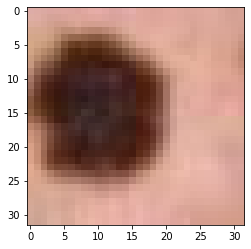

In [64]:
# One real image
from random import randint
single_img = plt.imread(os.path.join(unlbld_imgs_base_path,imgs_names_list[randint(0,total_imgs-1)]))
plt.imshow(single_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


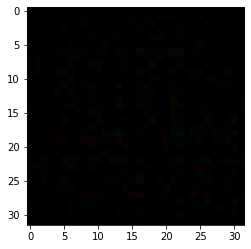

In [65]:
# One fake image
single_fake_img = G(tf.random.normal(shape=(1,100)))
plt.imshow(single_fake_img[0,:,:,:])

In [66]:
# Function to calculate loss of Discriminator 
def discriminator_base():

  input_to_cls = Input(shape=(32,32,3)) # output from Generator will be the input from Discriminator

  disc_base = Sequential(name="disc_base")
  disc_base.add(input_to_cls)

  for layer in D.layers[0:10]:
    disc_base.add(layer)

  return disc_base

# Now creating 2 classifiers in Discriminator cnn - Supervised and Unsupervised cls
def unsupervised_classifier():

  disc_base = discriminator_base()

  disc_base.add(Dense(units=1,activation="sigmoid"))

  return disc_base


def supervised_classifier():

  disc_base = discriminator_base()

  disc_base.add(Dense(units=1,activation="sigmoid"))

  return disc_base

In [67]:
# Instantiate the classifiers in Discriminator
unsupervised_cls = unsupervised_classifier()
supervised_cls = supervised_classifier()

In [68]:
# Optimize the classifiers to get minimum loss (We use Adam optimizer to calculate gradient descent on the mini batch)
unsupervised_cls_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0001,beta_1=0.3)
supervised_cls_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0001,beta_1=0.3)

In [69]:
# Metric to calculate the accuracy for BinaryClassifier
supervised_cls_train_acc_metric = tf.keras.metrics.BinaryAccuracy()
supervised_cls_cv_acc_metric = tf.keras.metrics.BinaryAccuracy()
supervised_cls_test_acc_metric = tf.keras.metrics.BinaryAccuracy()

In [70]:
# Function to calculate the loss of supervised and unsupervised classifier
def unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds):

  real_imgs_labels = tf.ones_like(real_imgs_preds)
  fake_imgs_labels = tf.zeros_like(fake_imgs_preds)

  real_imgs_loss = bce_loss(y_true=real_imgs_labels,y_pred=real_imgs_preds)
  fake_imgs_loss = bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

  total_loss = real_imgs_loss + fake_imgs_loss

  return total_loss

def supervised_cls_loss(imgs_labels,imgs_preds):

  return bce_loss(y_true=imgs_labels,y_pred=imgs_preds)

In [ ]:
# Function for training the model using semi seupervised learning
@tf.function
def ssl_training_step(labeled_images,unlabeled_images):

  G.trainable = False
  unsupervised_cls.trainable = True
  supervised_cls.trainable = True

  with tf.GradientTape() as supervised_cls_tape, tf.GradientTape() as unsupervised_cls_tape, tf.GradientTape() as gen_tape:

    labeled_imgs_preds = supervised_cls(labeled_images[0],training=True)
    
    supervised_loss = supervised_cls_loss(imgs_labels=labeled_images[1],imgs_preds=labeled_imgs_preds)

    # gradients of supervised layer
    gradients_of_supervised_cls = supervised_cls_tape.gradient(supervised_loss,supervised_cls.trainable_variables)
    supervised_cls_optimizer.apply_gradients(zip(gradients_of_supervised_cls,supervised_cls.trainable_variables))

    noise = tf.random.normal(shape=(batch_size,noise_shape))
    generated_images = G(noise,training=False)

    real_imgs_preds = unsupervised_cls(unlabeled_images,training=True)
    fake_imgs_preds = unsupervised_cls(generated_images,training=True)

    unsupervised_loss = unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds)

    # gradients of unsupervised layer
    gradients_of_unsupervised_cls = unsupervised_cls_tape.gradient(unsupervised_loss,unsupervised_cls.trainable_variables)
    unsupervised_cls_optimizer.apply_gradients(zip(gradients_of_unsupervised_cls,unsupervised_cls.trainable_variables))

    # supervised_cls.trainable = False
    # unsupervised_cls.trainable = False

  return supervised_loss,labeled_imgs_preds

In [ ]:
# creating subfolder for training data

train_dir = '/content/drive/MyDrive/MelanomaDetection/labeled'
zero_labeled_folder = os.path.join(train_dir,'zero_labeled_folder')
one_labeled_folder = os.path.join(train_dir,'one_labeled_folder')
os.mkdir(one_labeled_folder)
os.mkdir(zero_labeled_folder)
labeled_data_path = "/content/drive/MyDrive/MelanomaDetection/labeled"

for img_filename in os.listdir(labeled_data_path):
  
  if img_filename.endswith("0.jpg"):
    shutil.move(os.path.join(train_dir,img_filename),os.path.join(zero_labeled_folder,img_filename))

  elif img_filename.endswith("1.jpg"):
    shutil.move(os.path.join(train_dir,img_filename),os.path.join(one_labeled_folder,img_filename))

In [ ]:
# creating subfolder for teating_data

test_dir = '/content/drive/MyDrive/MelanomaDetection/test'
zero_test_folder = os.path.join(test_dir,'zero_test_folder')
one_test_folder = os.path.join(test_dir,'one_test_folder')
os.mkdir(one_test_folder)
os.mkdir(zero_test_folder)
test_data_path = "/content/drive/MyDrive/MelanomaDetection/test"

for img_filename in os.listdir(test_data_path):
  if img_filename.endswith("0.jpg"):
    shutil.move(os.path.join(test_dir,img_filename),os.path.join(zero_test_folder,img_filename))

  elif img_filename.endswith("1.jpg"):
    shutil.move(os.path.join(test_dir,img_filename),os.path.join(one_test_folder,img_filename))

In [ ]:
# Checkpoint for classifiers
cls_checkpoint_dir = "/content/drive/MyDrive/pure_supervised_cls_checkpoints_melanoma"
checkpoint_prefix = os.path.join(cls_checkpoint_dir,"ckpt")
cls_checkpoint = tf.train.Checkpoint(optimizer=[supervised_cls_optimizer,unsupervised_cls_optimizer],
                                     model=[supervised_cls,unsupervised_cls])

In [ ]:
cls_epochs = 200

In [ ]:
cv_data_gen = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True)
cv_datagen = cv_data_gen.flow_from_directory(directory="/content/drive/MyDrive/MelanomaDetection/test",
                                             target_size=(32,32),
                                             classes=os.listdir("/content/drive/MyDrive/MelanomaDetection/test"),
                                             class_mode="binary",batch_size=150)

In [ ]:
labeled_data_gen = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True)
labeled_datagen = labeled_data_gen.flow_from_directory(directory="/content/drive/MyDrive/MelanomaDetection/labeled",
                                                       target_size=(32,32),
                                                       classes=os.listdir("/content/drive/MyDrive/MelanomaDetection/labeled"),
                                                       class_mode="binary",batch_size=7)

In [ ]:
def train_ssl_classifier(labeled_imgs_datagen,unlabeled_imgs_datagen,cv_imgs_datagen,total_epochs):

  for epoch in range(total_epochs):

    time_step = 1

    for labeled_images_batch, unlabeled_images_batch in zip(labeled_imgs_datagen,unlabeled_imgs_datagen):

      supervised_loss, labeled_imgs_preds = ssl_training_step(labeled_images=labeled_images_batch,unlabeled_images=unlabeled_images_batch[0])

      if time_step > len(os.listdir("/content/drive/MyDrive/MelanomaDetection/unlabeled"))//batch_size:
        break

      supervised_cls_train_acc_metric.update_state(labeled_images_batch[1],labeled_imgs_preds)
      print("Training Loss at Time Step {} of Epoch {} is {}".format(time_step,epoch+1,float(supervised_loss)))

      time_step = time_step + 1

    training_accuracy = supervised_cls_train_acc_metric.result()
    print("\nTraining Accuracy after Epoch {} is {}".format(epoch+1,float(training_accuracy)))

    supervised_cls_train_acc_metric.reset_states()

    cv_time_steps = 0

    for X_cv,Y_cv_labels in cv_imgs_datagen:

      if cv_time_steps > 300//150:
        break

      cv_time_steps = cv_time_steps + 1

      Y_cv_preds = supervised_cls(X_cv,training=False)
      supervised_cls_cv_acc_metric.update_state(Y_cv_labels,Y_cv_preds)

    cv_accuracy = supervised_cls_cv_acc_metric.result()
    print("Cross Validation Accuracy after Epoch {} is {}\n".format(epoch+1,float(cv_accuracy)))

    supervised_cls_cv_acc_metric.reset_states()

    cls_checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
train_ssl_classifier(labeled_imgs_datagen=labeled_datagen,unlabeled_imgs_datagen=unlabeled_datagen,
                     cv_imgs_datagen=cv_datagen,total_epochs=cls_epochs)

In [ ]:
test_data_generator = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True)
test_datagen = test_data_generator.flow_from_directory(directory="/content/drive/MyDrive/MelanomaDetection/MelanomaDetection/MelanomaDetection/test",
                                                        target_size=(32,32),
                                                       classes=os.listdir("/content/drive/MyDrive/MelanomaDetection/MelanomaDetection/MelanomaDetection/test"),
                                                       class_mode="binary",batch_size=600)

In [ ]:
test_pred = supervised_cls(test_datagen[0][0])

In [ ]:
supervised_cls_test_acc_metric.update_state(test_datagen[0][1],test_pred)

In [ ]:
accuracy = float(supervised_cls_test_acc_metric.result())

In [ ]:
accuracy